In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from xgboost import XGBClassifier


In [45]:
X_full = pd.read_csv('./dataset_Caso_1.csv')
y = X_full.target
X_full.drop(['target'], axis=1, inplace=True)

# Pre-procesamiento
## Normalización
No se normalizó los datos ya que al modelo elegido casi no le afecta debido a que está compuesto por árboles.

## One Hot Encoding
Se transformó las columnas de tipo categóricas x3 y x4 con one hot encoding.

# Modelo
Existe un gran desbalance en el target ya que hay 22 filas positicas y 1978 filas negativas.
Se utilizó el modelo XGBClassifier con: $$scale\_pos\_weight = sum(negative\_instances) / sum(positive\_instances)$$ para compensar el desbalance de las clases.

# Cross-validation
Se utilizó validación cruzada para obtener las métricas de desempeño, ya que hay pocos datos con target = 1, lo que provoca que los resultados varíen significativamente dependiendo del conjunto de datos elegido para la evaluación.

Fold 1
Count Valid fold 1:  6


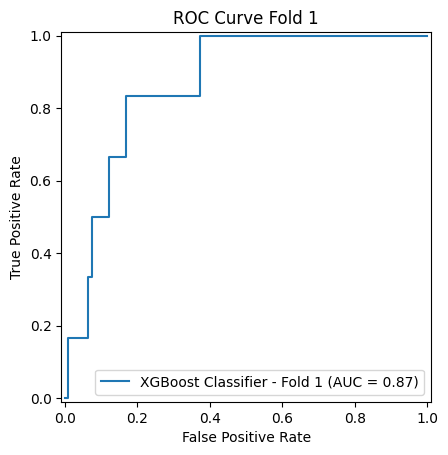

Fold 2
Count Valid fold 2:  6


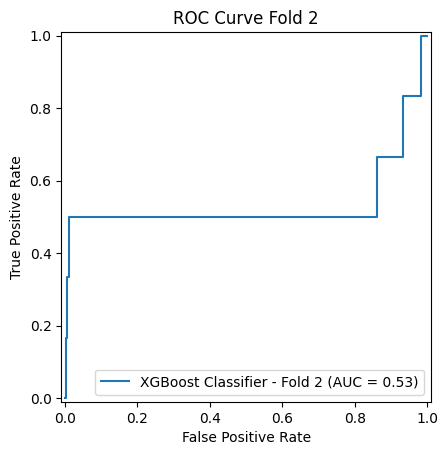

Fold 3
Count Valid fold 3:  4


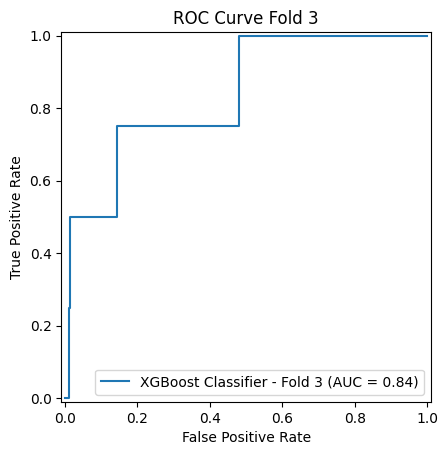

Fold 4
Count Valid fold 4:  2


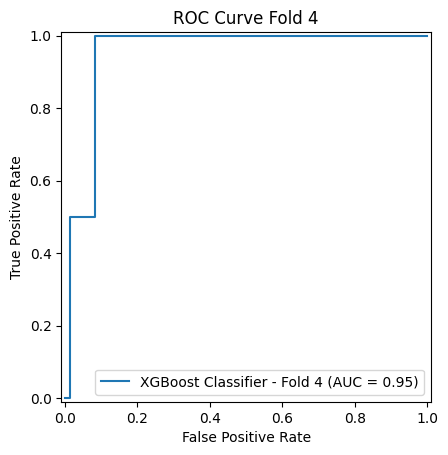

Fold 5
Count Valid fold 5:  4


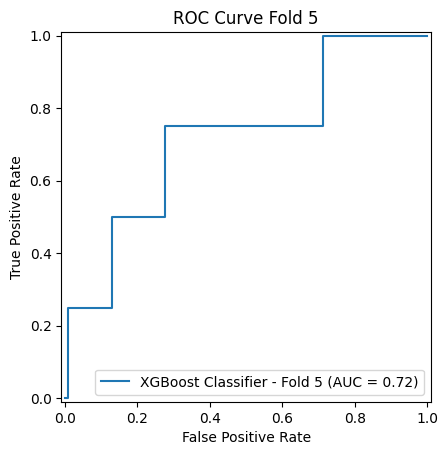

ROC AUC scores for each fold train: [1.0, 1.0, 1.0, 1.0, 1.0]
ROC AUC scores for each fold validation: [0.8654822335025382, 0.5342639593908629, 0.8371212121212122, 0.9510050251256281, 0.7184343434343434]
F1 scores for each fold validation: [0.18181818181818182, 0.2222222222222222, 0.3333333333333333, 0.0, 0.16666666666666666]
Average ROC AUC score train: 1.0
Average ROC AUC score validation: 0.781261354714917
Average F1 score validation: 0.1808080808080808


In [46]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

roc_auc_scores_train = []
roc_auc_scores_valid = []
f1_score_valid = []

for fold, (train_index, valid_index) in enumerate(kf.split(X_full)):
    print(f"Fold {fold+1}")
    X_train, X_valid = X_full.iloc[train_index], X_full.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # One-hot encoding
    X_train = pd.get_dummies(X_train)
    X_valid = pd.get_dummies(X_valid)
    X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

    # Model
    # Compensating for unbalanced classes with scale_pos_weight
    model = XGBClassifier(scale_pos_weight=sum(y_train == 0)/sum(y_train == 1),random_state=0)
    model.fit(X_train, y_train)

    # AUC train
    preds_train = model.predict_proba(X_train)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_train, preds_train)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_scores_train.append(roc_auc)

    # AUC validation
    preds_valid = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, preds_valid)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_scores_valid.append(roc_auc)

    # F1 score validation
    y_pred = model.predict(X_valid)
    f1 = metrics.f1_score(y_valid, y_pred)
    f1_score_valid.append(f1)

    print(f'Count Valid fold {fold+1}: ',sum(y_valid))

    # Display ROC
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name=f'XGBoost Classifier - Fold {fold+1}')
    display.plot()
    plt.title(f"ROC Curve Fold {fold+1}")
    plt.show()



print(f"ROC AUC scores for each fold train: {roc_auc_scores_train}")
print(f"ROC AUC scores for each fold validation: {roc_auc_scores_valid}")
print(f"F1 scores for each fold validation: {f1_score_valid}")
print(f"Average ROC AUC score train: {sum(roc_auc_scores_train)/len(roc_auc_scores_train)}")
print(f"Average ROC AUC score validation: {sum(roc_auc_scores_valid)/len(roc_auc_scores_valid)}")
print(f"Average F1 score validation: {sum(f1_score_valid)/len(f1_score_valid)}")


# Comentarios finales

Para concluir la evaluación, faltaría experimentar variando los parámetros del modelo, especialmente aquellos asociados a la regularización dentro de la función objetivo. Esto ayudaría a evitar el sobreajuste.